In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew
from scipy.stats import mode
from scipy.ndimage import interpolation as inter

In [49]:
def correct_skew(image, delta=1, limit=12):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,41,15)
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    return best_angle

def detect_lines(img): 
    image = img.copy()
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150,apertureSize=3)
    lines_list =[]
    lines = cv2.HoughLinesP(
                edges, # Input edge image
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=100, # Min number of votes for valid line
                minLineLength=5, # Min allowed length of line
                maxLineGap=10 # Max allowed gap between line for joining them
                )
    angles = []
    line_lengths = []
    total_weighted_angle = 0
    total_length = 0
    for points in lines:
        x1,y1,x2,y2=points[0]
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
        lines_list.append([(x1,y1),(x2,y2)])
        

        angle_rad = np.arctan2(y2 - y1, x2 - x1)
        angle_deg = np.degrees(angle_rad)
        angles.append(angle_deg)
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        line_lengths.append(length)
        total_weighted_angle += angle_deg * length
        total_length += length
    
    angles= np.array(angles)
    weighted_mean_angle = total_weighted_angle / total_length
    hist_angle = correct_skew(image)

    print("hough lines(mean) estimated rotation angle:", angles.mean())
    print("hough lines(median) estimated rotation angle:", np.median(angles))
    print("hough lines(mode) estimated rotation angle:", mode(angles)[0])
    print("hough lines(weighted mean) estimated rotation angle:", weighted_mean_angle)
    deskew_img = deskew(image.copy())
    print("hist-based estimated rotation angle:", hist_angle)

    fig,axes = plt.subplots(1,7, figsize=(15,5))
    axes[0].imshow(image)
    axes[0].set_title('input')
    axes[1].imshow((rotate(image.copy(), angle=angles.mean(), resize=True) * 255).astype(np.uint8))
    axes[1].set_title('hough mean')
    axes[2].imshow((rotate(image.copy(), angle=np.median(angles), resize=True) * 255).astype(np.uint8))   
    axes[2].set_title('hough median')
    axes[3].imshow((rotate(image.copy(), angle=mode(angles)[0], resize=True) * 255).astype(np.uint8))   
    axes[3].set_title('hough mode')
    axes[4].imshow((rotate(image.copy(), angle=weighted_mean_angle, resize=True) * 255).astype(np.uint8))
    axes[4].set_title('hough weighted mean')
    axes[5].imshow(deskew_img)   
    axes[5].set_title('deskewed')
    axes[6].imshow((rotate(image.copy(), angle=hist_angle, resize=True) * 255).astype(np.uint8))   
    axes[6].set_title('hist-rotated')
    plt.show() 
    
    fig,axes = plt.subplots(1,2, figsize=(5,3))
    axes[0].hist(angles, bins=360)
    axes[0].set_title('angles distribution')
    axes[1].hist(line_lengths, bins=10)
    axes[1].set_title('line lenths distribution')
    plt.show() 
    print("=================================================================\n")

def plot_rotated_lines(img):
    rot_angles = [0, 5, 10, 30, 45, 60, 90, 180, 270, 300, 330, 345, 355, 360]
    temp = img.copy()
    for theta in rot_angles:
        print("input rotation angle = ", theta)
        temp_rot = (rotate(temp, angle=theta, resize=True) * 255).astype(np.uint8)
        detect_lines(temp_rot)
def deskew(image):
    grayscale = rgb2gray(image)
    angle = np.round(determine_skew(grayscale),1)
    print("deskew computed angle:", angle)
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    return rotated

In [3]:
pdf = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_optimal_gt/_6.mp4_2365.png')
img1 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_6.mp4_2411.png')
img2 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_14.MP4_7638.png')
img3 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_14.MP4_6480.png')
img4 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_12.mp4_2299.png')
img5 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_10.mp4_8220.png')
img6 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_12.mp4_1918.png')

In [4]:
def detect_hv_lines(img): 
    image = img.copy()
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150,apertureSize=3)
    lines_list =[]
    lines = cv2.HoughLinesP(
                edges, # Input edge image
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=100, # Min number of votes for valid line
                minLineLength=5, # Min allowed length of line
                maxLineGap=10 # Max allowed gap between line for joining them
                )
    angles = []
    line_lengths = []
    total_weighted_angle = 0
    total_length = 0
    for points in lines:
        x1,y1,x2,y2=points[0]
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
        lines_list.append([(x1,y1),(x2,y2)])
        angle_rad = np.arctan2(y2 - y1, x2 - x1)
        angle_deg = np.degrees(angle_rad)
        angles.append(angle_deg)
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        line_lengths.append(length)
        total_weighted_angle += angle_deg * length
        total_length += length
    
    angles= np.array(angles)
    weighted_mean_angle = total_weighted_angle / total_length

    print("hough lines(mean) estimated rotation angle:", angles.mean())
    print("hough lines(median) estimated rotation angle:", np.median(angles))
    print("hough lines(mode) estimated rotation angle:", mode(angles)[0])
    print("hough lines(weighted mean) estimated rotation angle:", weighted_mean_angle)

    fig,axes = plt.subplots(1,5, figsize=(15,5))
    axes[0].imshow(image)
    axes[0].set_title('input')
    axes[1].imshow((rotate(image.copy(), angle=angles.mean(), resize=True) * 255).astype(np.uint8))
    axes[1].set_title('hough mean')
    axes[2].imshow((rotate(image.copy(), angle=np.median(angles), resize=True) * 255).astype(np.uint8))   
    axes[2].set_title('hough median')
    axes[3].imshow((rotate(image.copy(), angle=mode(angles)[0], resize=True) * 255).astype(np.uint8))   
    axes[3].set_title('hough mode')
    axes[4].imshow((rotate(image.copy(), angle=weighted_mean_angle, resize=True) * 255).astype(np.uint8))
    axes[4].set_title('hough weighted mean')

    plt.show() 
    
    fig,axes = plt.subplots(1,2, figsize=(5,3))
    axes[0].hist(angles, bins=360)
    axes[0].set_title('angles distribution')
    axes[1].hist(line_lengths, bins=10)
    axes[1].set_title('line lenths distribution')
    plt.show() 
    print("=================================================================\n")

def deskew2(image):
    ar = image.shape[0]/image.shape[1]
    grayscale = rgb2gray(image)
    angle = np.round(determine_skew(grayscale),1)
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    # rotated2 = detect_hv_lines(rotated)
    fig,axes = plt.subplots(1,2)
    axes[0].imshow(image)
    axes[0].set_title('input')
    axes[1].imshow(rotated)
    axes[1].set_title('rotated')
    # axes[2].imshow(rotated2)
    # axes[2].set_title('rotated-vert')

    return rotated

hough lines(mean) estimated rotation angle: -2.4808850099103537
hough lines(median) estimated rotation angle: 0.0
hough lines(mode) estimated rotation angle: 0.0
hough lines(weighted mean) estimated rotation angle: -0.7239695977530015


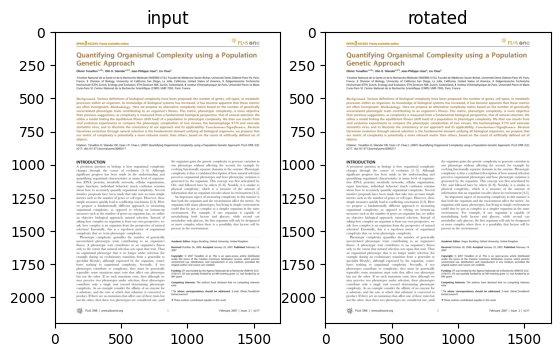

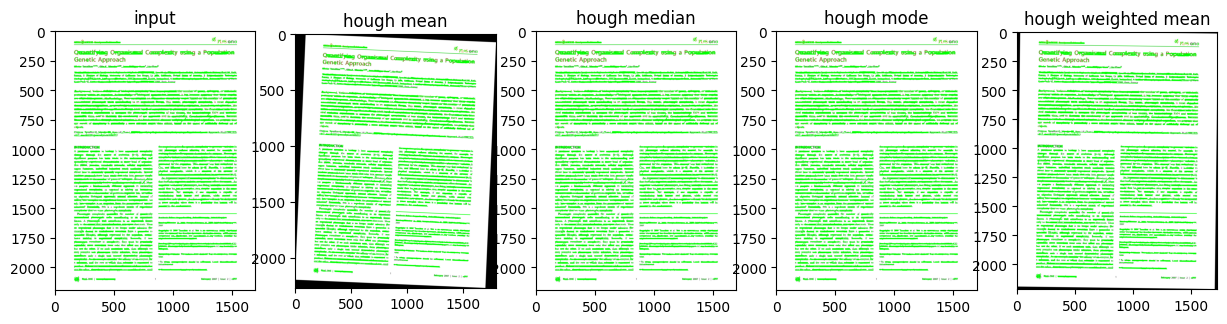

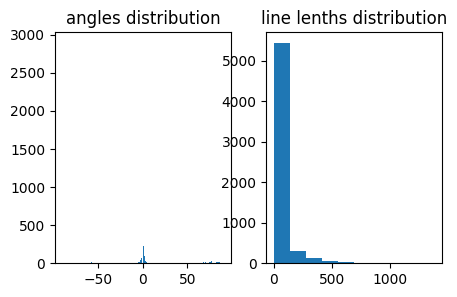

In [30]:
r = deskew2(pdf)
detect_hv_lines(r)

hough lines(mean) estimated rotation angle: 2.0482930542038544
hough lines(median) estimated rotation angle: 4.807953963030471
hough lines(mode) estimated rotation angle: -90.0
hough lines(weighted mean) estimated rotation angle: -12.20595793986372


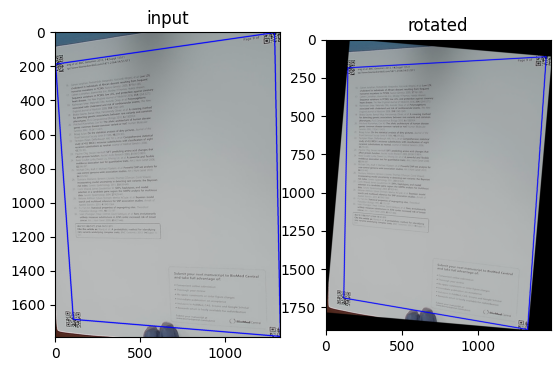

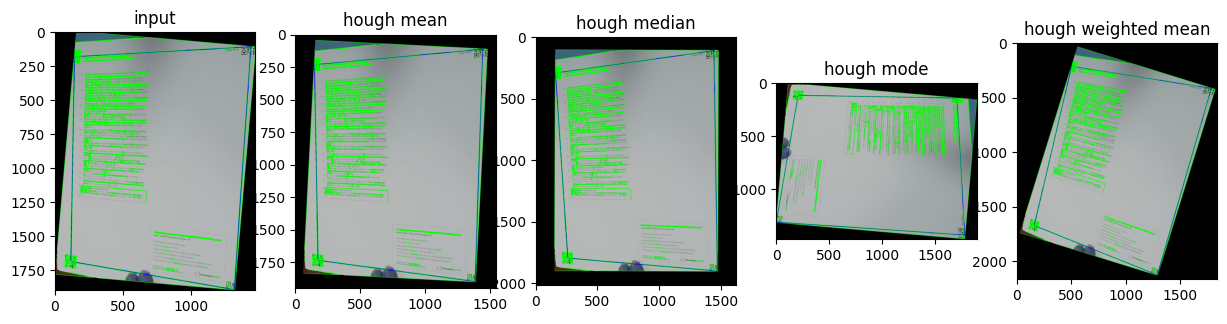

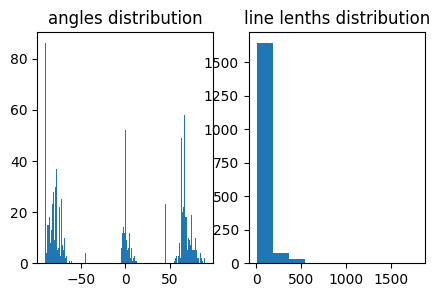

In [29]:
r = deskew2(img2)
detect_hv_lines(r)

hough lines(mean) estimated rotation angle: 2.0482930542038544
hough lines(median) estimated rotation angle: 4.807953963030471
hough lines(mode) estimated rotation angle: -90.0
hough lines(weighted mean) estimated rotation angle: -12.20595793986372


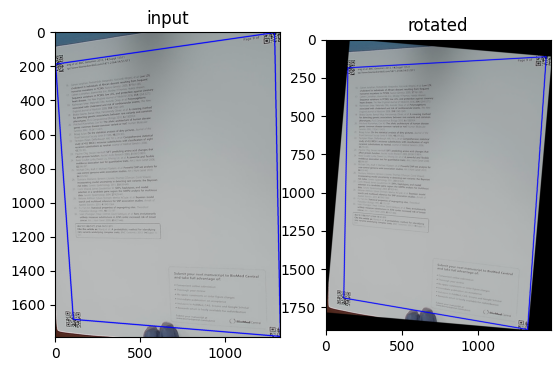

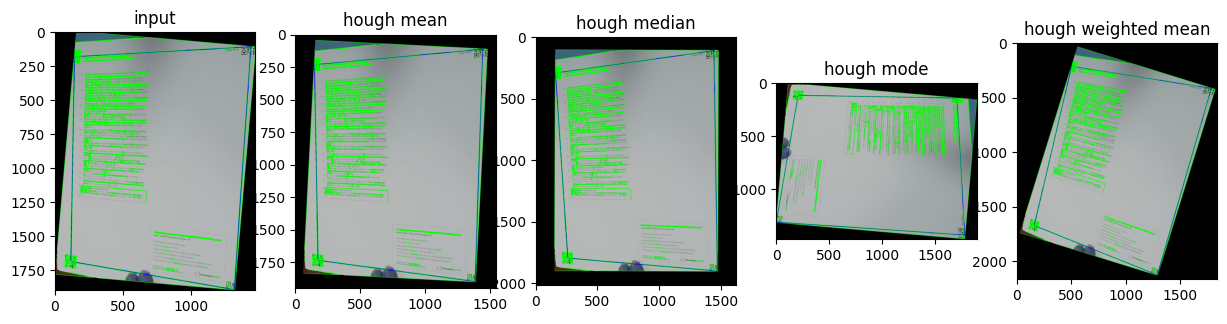

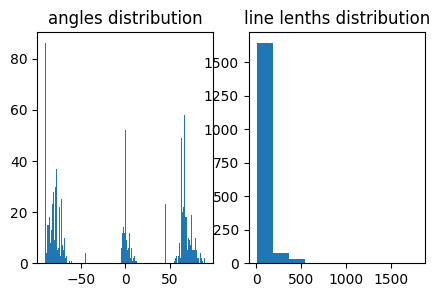

In [28]:
r = deskew2(img2)
detect_hv_lines(r)

hough lines(mean) estimated rotation angle: -1.421538144268899
hough lines(median) estimated rotation angle: 2.3859440303888126
hough lines(mode) estimated rotation angle: -45.0
hough lines(weighted mean) estimated rotation angle: -1.0057136679453162


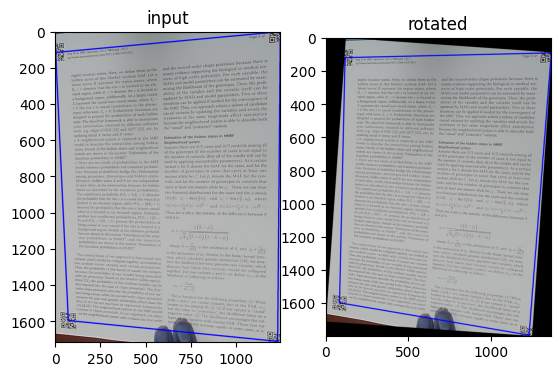

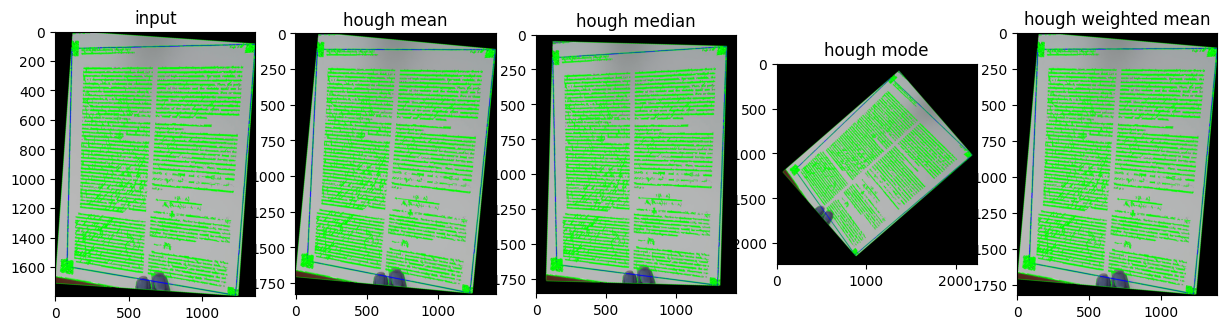

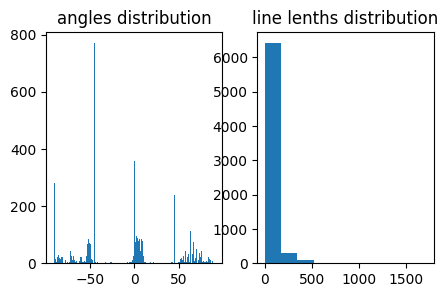

In [27]:


r = deskew2(img3)
detect_hv_lines(r)

hough lines(mean) estimated rotation angle: -11.79971194031703
hough lines(median) estimated rotation angle: -7.125016348901798
hough lines(mode) estimated rotation angle: 0.0
hough lines(weighted mean) estimated rotation angle: -16.296160105970618


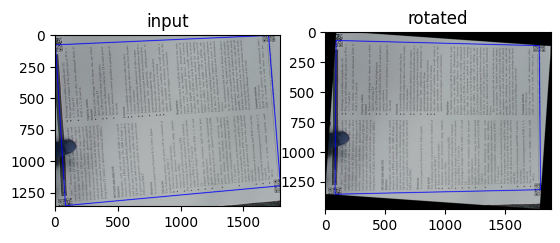

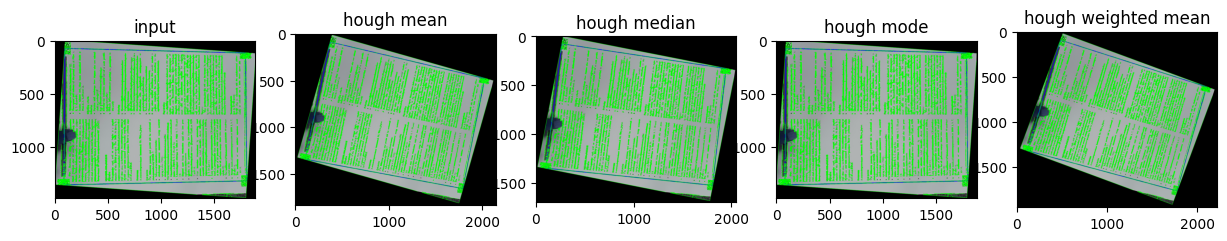

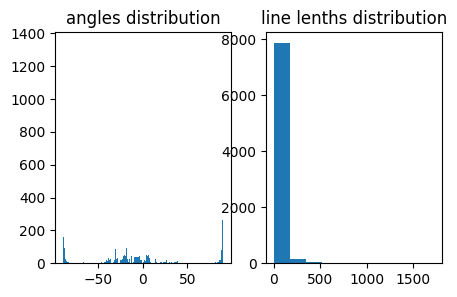

In [32]:
r4 = deskew2(img4)
detect_hv_lines(r4)

hough lines(mean) estimated rotation angle: 0.8975874115874533
hough lines(median) estimated rotation angle: 0.0
hough lines(mode) estimated rotation angle: 0.0
hough lines(weighted mean) estimated rotation angle: 4.857793172440116


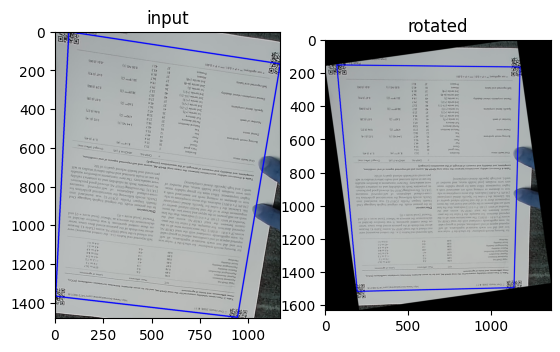

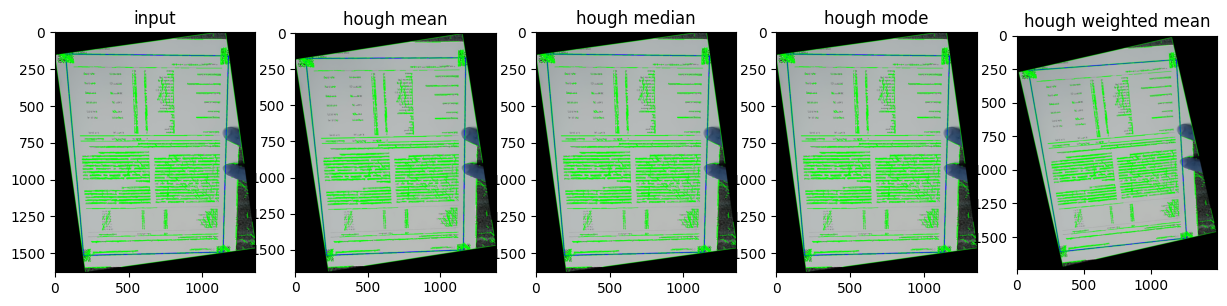

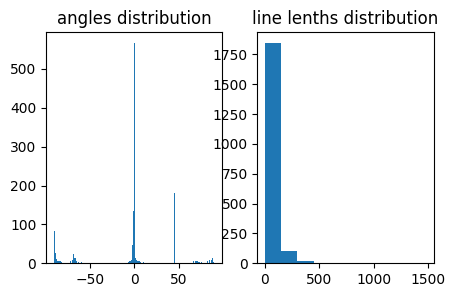

In [24]:

r = deskew2(img5)
detect_hv_lines(r)

hough lines(mean) estimated rotation angle: -20.396872183550233
hough lines(median) estimated rotation angle: -9.462322208025617
hough lines(mode) estimated rotation angle: -90.0
hough lines(weighted mean) estimated rotation angle: -51.52347457800318


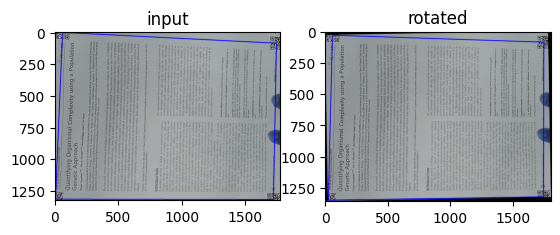

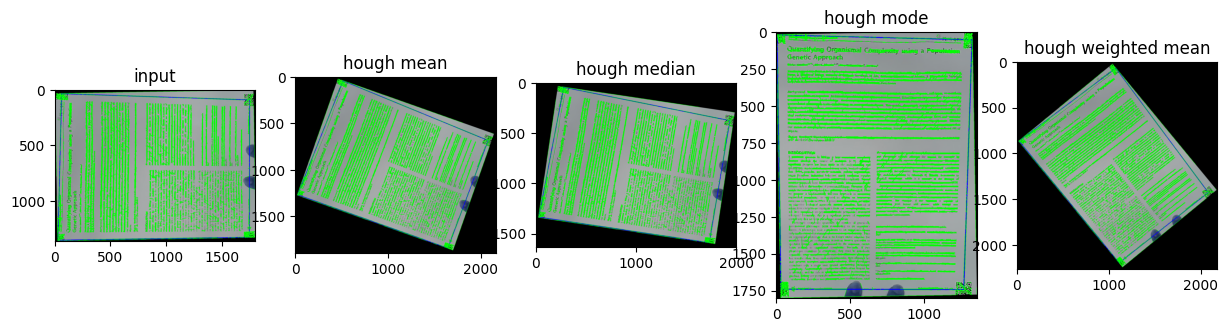

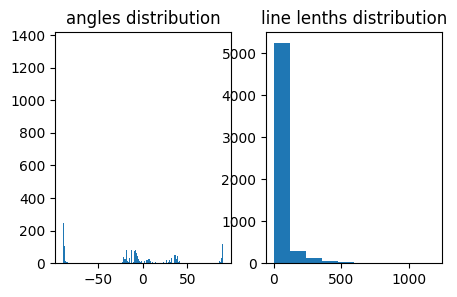

In [23]:

r = deskew2(img6)
detect_hv_lines(r)

In [34]:
def detect_text_direction(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  longest_horizontal = 0
  longest_vertical = 0
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if abs(w - h) < 10:  # Ignore squares (potential noise)
      continue
    if w > h:
      longest_horizontal = max(longest_horizontal, w)
    else:
      longest_vertical = max(longest_vertical, h)
  print(longest_horizontal, longest_vertical)
  if longest_horizontal > longest_vertical:
    return 0
  else:
    return 1

In [110]:
def detect_text_orientation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(255 - edges, 1, np.pi / 180, 100)
    horizontal_lines, vertical_lines = 0, 0
    horizontal_lines_lengths, vertical_lines_lengths = [],[]
    all_angles, all_lines = [], []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            all_angles.append(np.degrees(theta))
            all_lines.append(rho)
            if theta < np.pi / 4 or theta > 3 * np.pi / 4:
                vertical_lines += 1
                vertical_lines_lengths.append(rho)
            else:
                horizontal_lines += 1
                horizontal_lines_lengths.append(rho)
    h_len = np.median(np.array(horizontal_lines_lengths))
    v_len = np.median(np.array(vertical_lines_lengths))
    all_angles = np.array(all_angles)
    all_lines = np.array(all_lines)
    print("n_hor:",horizontal_lines,", n_vert:", vertical_lines)
    print("avg_hor:",h_len, ", vert:",v_len )
    print("avg_angle:",all_angles.mean(), np.median(all_angles) )
    sum_products = np.sum(all_angles * all_lines)
    sum_weights = np.sum(all_lines)
    weighted_mean_value = sum_products / sum_weights
    print("weighted mean_angle:",weighted_mean_value)
    print(np.quantile(all_angles, [0.1,0.2,0.5, 0.8,0.9, 0.95,0.99]))

n_hor: 18296 , n_vert: 14360
avg_hor: 861.0 , vert: 528.0
avg_angle: 81.24238 77.0
weighted mean_angle: 49.930237
[ 15.99999905  36.99999619  77.         128.99998474 161.
 171.99998474 178.        ]


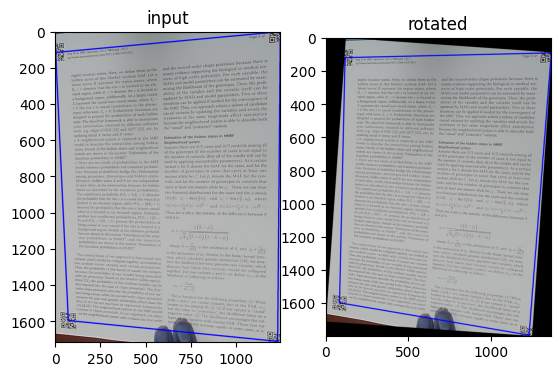

In [111]:
detect_text_orientation(deskew2(img3))

n_hor: 15245 , n_vert: 17625
avg_hor: 787.0 , vert: 477.0
avg_angle: 81.01999 74.99999
weighted mean_angle: 20.839994
[ 15.          31.99999809  74.99999237 135.99998474 163.99998474
 171.99998474 178.        ]


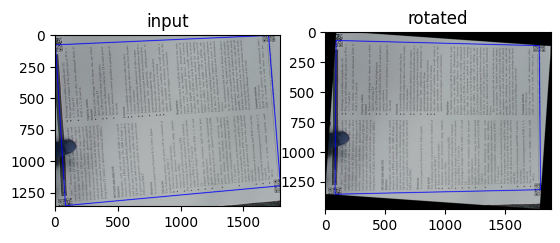

In [112]:
detect_text_orientation(deskew2(img4))

n_hor: 3568 , n_vert: 6603
avg_hor: 567.0 , vert: 270.0
avg_angle: 89.821945 89.0
weighted mean_angle: 35.218483
[ 12.          27.99999809  89.         151.99998474 166.99998474
 173.99998474 178.99998474]


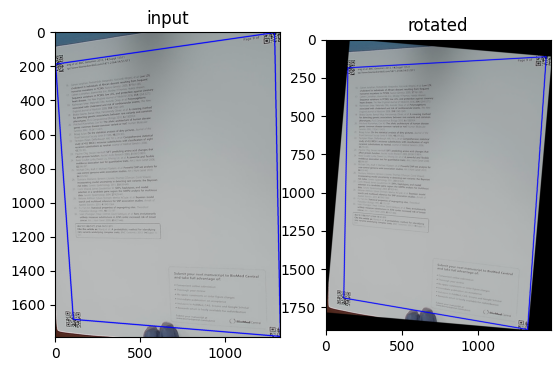

In [101]:
detect_text_orientation(deskew2(img2))

n_hor: 18605 , n_vert: 16690
avg_hor: 836.0 , vert: 388.5
avg_angle: 90.57028 90.99999
weighted mean_angle: 51.22317
[ 18.          39.          90.99999237 140.99998474 161.
 170.99998474 178.        ]


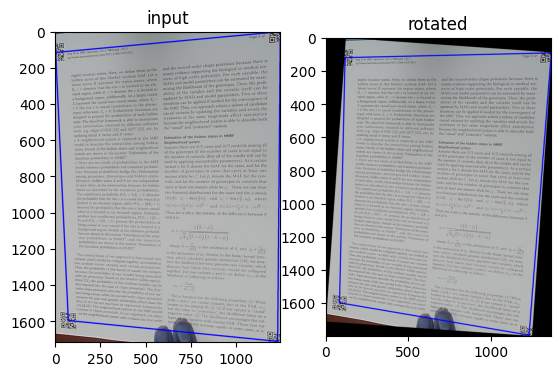

In [103]:
detect_text_orientation(deskew2(img3))

intial AR: 1.378313253012048
angle: -4.0
rotated AR: 1.3208516886930983


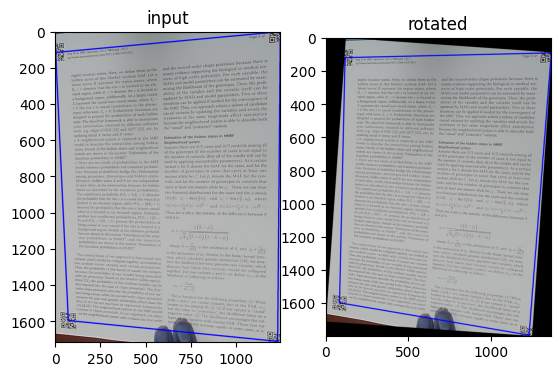

In [16]:
deskew2(img3)

intial AR: 0.7569676700111483
angle: -4.0
rotated AR: 0.7855626326963907


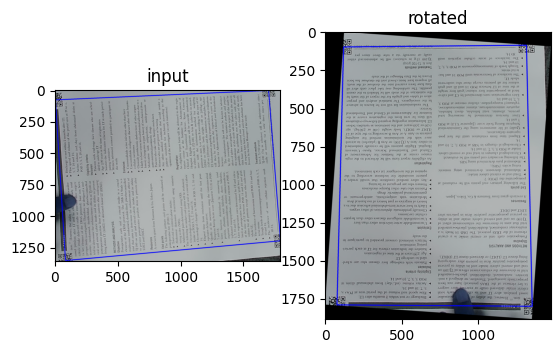

In [17]:
deskew2(img4)

intial AR: 1.2710120068610635
angle: 8.0
rotated AR: 1.1976487876561352


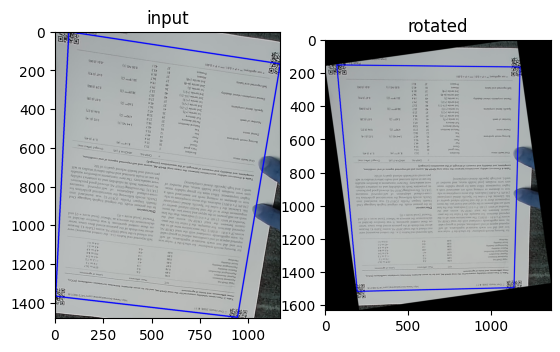

In [18]:
deskew2(img5)

intial AR: 0.744943820224719
angle: 1.0
rotated AR: 0.7526344980587909


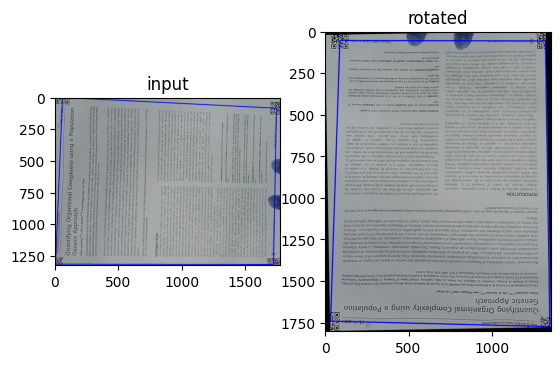

In [19]:
deskew2(img6)

In [25]:
def count_text_lines(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
    num_lines = len(contours)
    plt.imshow(binary_image,cmap='gray')
    plt.show()
    plt.imshow(image_with_contours)
    plt.show()
    return num_lines

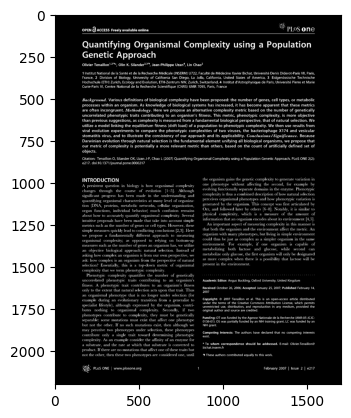

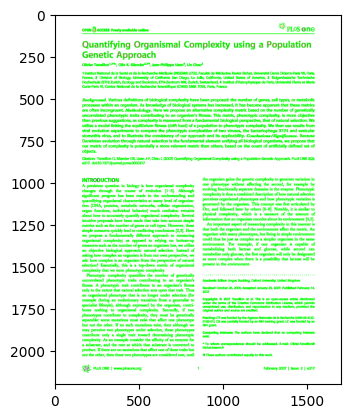

7435

In [26]:
count_text_lines(pdf)

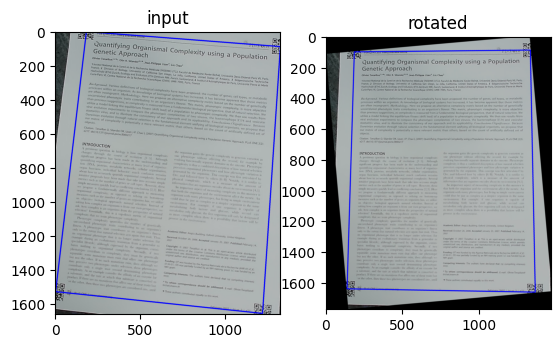

In [27]:
r1 = deskew2(img1)

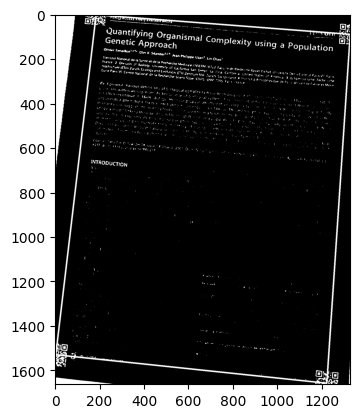

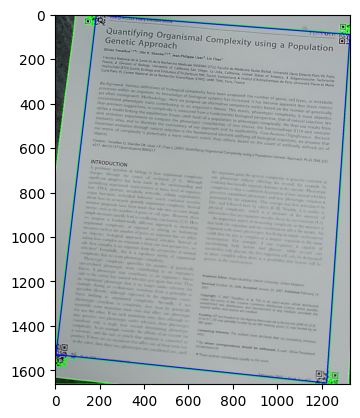

24

In [28]:
count_text_lines(img1)

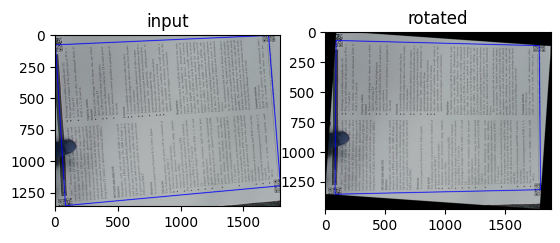

In [29]:
r4 = deskew2(img4)

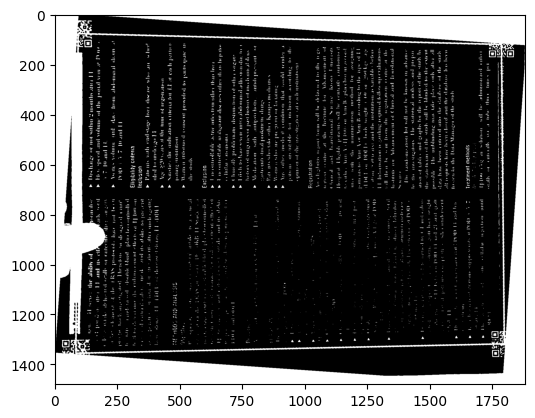

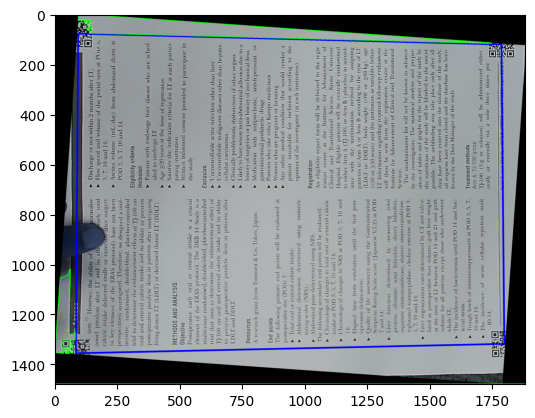

7

In [30]:
count_text_lines(r4)